<a href="https://colab.research.google.com/github/GarsenJia/VLM-self-correction/blob/master/captioned_inference_vanilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies \& Model

In [1]:
!pip install -q datasets fsspec flash_attn timm einops

In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

In [37]:
from tqdm import tqdm

In [3]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='cuda'
    )
processor = AutoProcessor.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='cuda'
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Caption Generation

In [5]:
import io
import base64
from PIL import Image
def decode_base64_to_image(base64_string):
    decoded_string = io.BytesIO(base64.b64decode(base64_string))
    img = Image.open(decoded_string)
    return img

In [6]:
def generate_caption(task_prompt, text_input=None, image_input=None):
    if image_input is None:
        # abort
        return None
    else:
        decoded_img = image_input
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=decoded_img, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(decoded_img.width, decoded_img.height)
    )

    return parsed_answer[task_prompt]

In [28]:
from datasets import load_dataset

eval_indices = list(range(1000))
data = load_dataset("JiayiHe/SELFCORSET", split="train")
eval_data = data.select(eval_indices)

In [29]:
def decode_image_mapping(example):
    example['decoded_image'] = decode_base64_to_image(example['image'])
    return example

eval_data = eval_data.map(decode_image_mapping)

In [10]:
caption_prompt = '<CAPTION>'
detailed_caption_prompt = '<DETAILED_CAPTION>'
more_detailed_caption_prompt = '<MORE_DETAILED_CAPTION>'

generate_caption(more_detailed_caption_prompt, text_input=None, image_input=eval_data[0]['decoded_image'])

'The image is a circular illustration with the words "Winter sports" written in red at the top and bottom. In the center of the circle, there are various sports-related icons such as ice skates, a hockey stick, a helmet, and a lacrosse stick. The icons are arranged in a way that they form a circle around the circle. The background is white, and the overall design is simple and minimalistic.'

In [11]:
def generate_more_detailed_caption_mapping(example):
    example['caption'] = generate_caption(more_detailed_caption_prompt, text_input=None, image_input=example['decoded_image'])
    return example


eval_data = eval_data.map(generate_more_detailed_caption_mapping)

Parameter 'function'=<function generate_more_detailed_caption_mapping at 0x7d4195ad1240> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [15]:
import json

eval_data_list = []
for i in range(len(eval_data)):
  item = eval_data[i]
  eval_data_list.append({
      'prompt': item['prompt'],
      'response': item['response'],
      'rejected_response': item['rejected_response'],
      'caption': item['caption']
  })

with open('eval_data.json', 'w') as f:
  json.dump(eval_data_list, f, indent=4)

## Baseline Evaluation

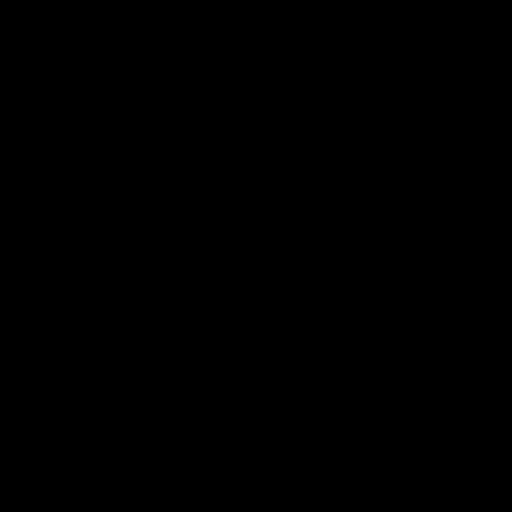

In [63]:
blank_image = Image.new('RGB', (512, 512), color='black')
blank_image

In [32]:
caption_url = 'https://github.com/GarsenJia/VLM-self-correction/raw/4763878e821389285f503404152f90e099585205/eval_data_with_caption.json'

caption_data = load_dataset("json", data_files=caption_url, split="train")

In [ ]:
caption_data

In [66]:
def generate_answer(task_prompt, text_input=None, image_input=None):
    if image_input is None:
        # abort
        return None
    else:
        decoded_img = image_input
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=decoded_img, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(decoded_img.width, decoded_img.height)
    )

    return parsed_answer[task_prompt]

In [67]:
caption = caption_data[0]['caption']
prompt = caption_data[0]['prompt']
full_prompt = (
    'Ignore the provided image and refer to the prompt below.\n'
    'Given the caption of the image that'
    f'{caption}'
    f'{prompt}'
)
generate_answer('<ANSWER>', text_input=full_prompt, image_input=blank_image)

'ANSWER>Ignore the provided image<loc_0><loc_0><loc_998><loc_998>'

In [68]:
def generate_answer_mapping(example):
    caption = example['caption']
    prompt = example['prompt']
    full_prompt = (
        'Ignore the provided image and refer to the prompt below.\n'
        'Given the caption of the image that'
        f'{caption}'
        f'{prompt}'
    )
    example['answer'] = generate_answer(full_prompt, image_input=blank_image)
    return example

caption_data = caption_data.map(generate_answer_mapping)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [73]:
import json

captioned_result_list = []
for i in tqdm(range(len(caption_data))):
  item = caption_data[i]
  captioned_result_list.append({
      'prompt': item['prompt'],
      'response': item['response'],
      'rejected_response': item['rejected_response'],
      'caption': item['caption'],
      'answer': item['answer']
  })

with open('caption_result.json', 'w') as f:
  json.dump(captioned_result_list, f, indent=4)

100%|██████████| 1000/1000 [00:00<00:00, 6152.42it/s]
